***
<center><img src='https://github.com/HesamAsad/HesamAsad.github.io/blob/main/images/LOGO_EN_blue.png?raw=true' width=250/></center>

# <center>
## <center><span style='font-family:"Times New Roman"'><span style='background:dark'>  <font color='#1966ab'>$\LARGE{\text{Sharif University of Technology}}$</font>  <br>  <br>  <font color='#FFFFCC'>$\Large{\text{Masoud Tahmasbi}}$ </font> <br> <font color='#FFFFCC'>$\normalsize {\text{Student ID: } 402200275}$ </font>  <br>  <br> <font color='#33FFCC'>$\large{\text{CE957: Reinforcement Learning}}$</font> <br>  <font color='#FFFF00'>$\normalsize{\text{Assignment #3 - REINFORCE and PPO}}$ </font>
<br>

***

# REINFORCE algorithm **(40 points)**

## Setup

We must first install the required packages.

In [ ]:
!pip -q install gymnasium[mujoco]
!pip install imageio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 20.1 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import random
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from collections import namedtuple, deque
import imageio

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, MultivariateNormal
from torch.distributions import Categorical
from copy import deepcopy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Explore the environment

We will train an REINFORCE agent on the `CartPole` environment.

This code displays a video given it's path.

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

Explore the `CartPole` environment using random actions. At each timestep, render the current frame, and use it to make a video of the trajectory.

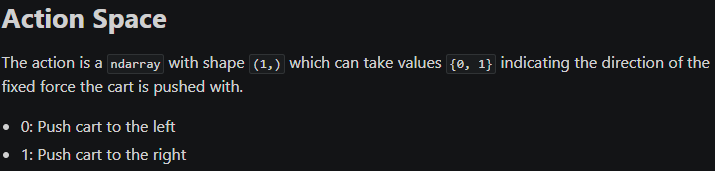

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.action_space

Discrete(2)

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
frames = []

env.reset()
for _ in range(100):
    frames.append(env.render())
    action = np.random.choice(2, 1)[0]
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        break
env.close()
imageio.mimsave('./CartPole.mp4', frames, fps=25)
show_video('./CartPole.mp4')


## Policy Network **(10 points)**

Complete the following code to build an agent that predicts the the probability of playing each action, given the state.

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNetwork, self).__init__()
        # TODO
        # Define the Policy Network architecture
        self.layer_stack_1 = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=output_size),
            nn.Softmax(dim=-1)
            )

    def forward(self, x):
        # TODO
        # predict the probability of playing each action
        action_probs = self.layer_stack_1(x)
        return action_probs

## Agent **(20 points)**

REINFORCE algorithm works by interacting with an environment by taking actions based on a policy. As the agent collects rewards from the environment, it records the outcomes and the **log probabilities** of the actions it took. At the end of an episode, the algorithm calculates the total **discounted reward** from each step—this is known as the return.

$$ R_t = \sum_{k=t}^{T} \gamma^{k-t} r_k
 $$

These returns are used to weight the logged probabilities, actions that lead to higher returns are made more probable.


$$ \theta \leftarrow \theta + \alpha \sum_{t=0}^{T-1} \gamma^t R_t \nabla_\theta \log \pi_\theta(a_t|s_t)
 $$


In [ ]:
class REINFORCEAgent:
    def __init__(self, policy, optimizer, gamma=0.99):
        self.policy = policy
        self.optimizer = optimizer
        self.gamma = gamma
        self.log_probs = []
        self.rewards = []

    def select_action(self, state):
        # TODO
        # select an action by sampling from the actor's response
        action_probs = self.policy(state)
        action_distribution = Categorical(action_probs)
        action = action_distribution.sample()
        self.log_probs.append(action_distribution.log_prob(action))
        return action.item()

    def update_policy(self):
        R = 0
        policy_loss = []
        returns = []

        # TODO
        # Calculate the discounted reward
        for i,r in enumerate(self.rewards[::-1]):
            R = R * self.gamma + r
            self.rewards[i] = R
        self.rewards = self.rewards[::-1]

        returns = torch.tensor(self.rewards)

        # TODO
        # Calculate the policy loss
        log_probs = torch.stack(self.log_probs)


        self.optimizer.zero_grad()
        policy_loss = torch.dot(-log_probs, returns)
        policy_loss.backward()
        self.optimizer.step()

        # Reset the rewards and log probabilities
        del self.rewards[:]
        del self.log_probs[:]

    def store_reward(self, reward):
        self.rewards.append(reward)


## Training **(5 points)**

Define the hyperparameters and complete the training loop.

In [ ]:
env = gym.make('CartPole-v1')
input_size = 4
output_size = 2
lr = 7e-4

policy = PolicyNetwork(input_size, 128, output_size)
optimizer = optim.Adam(policy.parameters(), lr=lr)
agent = REINFORCEAgent(policy, optimizer)

num_episodes = 1001

for episode in range(num_episodes):
    state, info = env.reset()
    total_reward = 0

    # TODO
    # collect rewards and log probabilities for updating the policy in a loop
    while True:
        action = agent.select_action(torch.FloatTensor(state))
        next_state, reward, done, _, _ = env.step(action)
        agent.rewards.append(reward)
        total_reward += reward
        state = next_state

        if done:
            break
    agent.update_policy()

    if episode % 50 == 0:
        print(f'Episode {episode+1}: Total Reward = {total_reward}')
env.close()

Episode 1: Total Reward = 19.0
Episode 51: Total Reward = 20.0
Episode 101: Total Reward = 31.0
Episode 151: Total Reward = 71.0
Episode 201: Total Reward = 83.0
Episode 251: Total Reward = 26.0
Episode 301: Total Reward = 74.0
Episode 351: Total Reward = 120.0
Episode 401: Total Reward = 95.0
Episode 451: Total Reward = 60.0
Episode 501: Total Reward = 181.0
Episode 551: Total Reward = 158.0
Episode 601: Total Reward = 357.0
Episode 651: Total Reward = 140.0
Episode 701: Total Reward = 547.0
Episode 751: Total Reward = 245.0
Episode 801: Total Reward = 378.0
Episode 851: Total Reward = 235.0
Episode 901: Total Reward = 178.0
Episode 951: Total Reward = 156.0
Episode 1001: Total Reward = 868.0


## Evaluation **(5 points)**

Here we use the trained agent and collect a trajectory using it's policy. Calculate the cumulative reward by adding rewards in each time space. Save and display the video of this run in the end.

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, _ = env.reset()
frames = []

total_reward = 0
# TODO
num_of_episodes = 1
state
# run the policy in the environment in a loop
for episode in range(num_of_episodes):
    state, info = env.reset()
    total_reward = 0

    while True:
        frames.append(env.render())
        action = agent.select_action(torch.FloatTensor(state))
        next_state, reward, done, _, _ = env.step(action)
        agent.rewards.append(reward)
        total_reward += reward
        state = next_state

        if done:
            break

env.close()
print(f'Total Reward: {total_reward}')

imageio.mimsave('./eval_reinforce.mp4', frames, fps=25)
show_video('./eval_reinforce.mp4')

Total Reward: 1048.0


# Proximal Policy Optimization **(60 points)**

## Setup

## Explore the environment

This code is essential for rendering MUJOCO based environments.

In [ ]:
# Configure MuJoCo to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


We will train a PPO agent in the `HalfCheetah` environment. This environment features continuous actions and more complex mechanics.

Explore this environment using random actions as well, and display the video of the resulting trajectory.

* What are the observation and action spaces of this environment? 17-6

* Are values bounded? No.

In [ ]:
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")
print("Action Space:",env.action_space, "\n", "Observation Space:",env.observation_space)

Action Space: Box(-1.0, 1.0, (6,), float32) 
 Observation Space: Box(-inf, inf, (17,), float64)


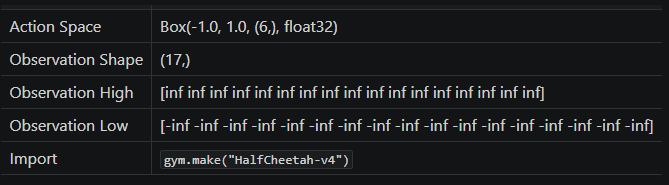

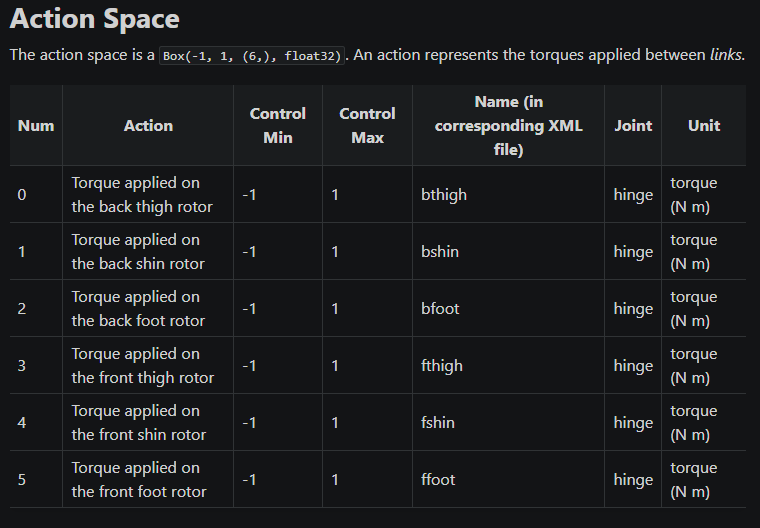

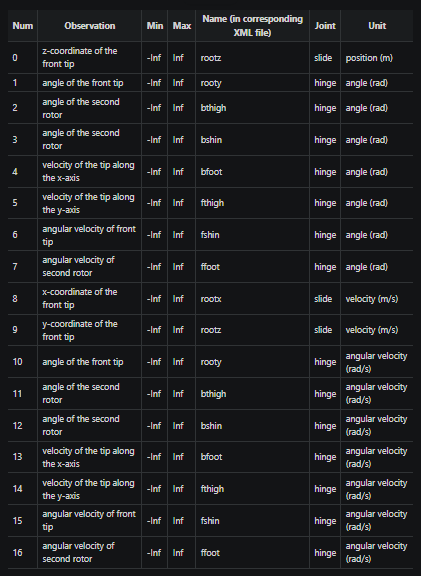

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

In [ ]:
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")
env.reset()
frames = []

for _ in range(100):
    frames.append(env.render())
    action = 2*np.random.rand(6) - 1 # 6 random numbers between -1 and +1
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        break
env.close()
imageio.mimsave('./HalfCheetah.mp4', frames, fps=25)
show_video('./HalfCheetah.mp4')

## Actor & Critic **(15 points)**

Proximal Policy Optimization (PPO) is an advanced reinforcement learning algorithm that uses separate actor and critic networks to optimize policy performance.

The actor network is responsible for predicting a probability distribution over actions (discrete) or estimating the value for each action (continuous), given the current state, while the critic network evaluates how good the action taken by the actor is, by predicting the reward based on state.


In [ ]:
class Actor(nn.Module):
    def __init__(self, state_dim, hidden_size, action_dim):
        super(Actor, self).__init__()
        # TODO
        # Define the Actor architecture
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mu_head = nn.Linear(hidden_size, action_dim)
        self.logstd = nn.Parameter(torch.zeros(1, action_dim))


    def forward(self, state):
        # TODO
        # In case of continuous environment, we usually
        # predict a mean and std for each action and sample
        # the action from a normal distribution
        x = F.tanh(self.fc1(state))
        x = F.tanh(self.fc2(x))
        mu = F.tanh(self.mu_head(x))
        std = torch.exp(self.logstd)
        return mu, std

class Critic(nn.Module):
    def __init__(self, state_dim, hidden_size):
        super(Critic, self).__init__()
        # TODO
        # Define the Critic architecture
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.value_head = nn.Linear(hidden_size, 1)

    def forward(self, state):
        # TODO
        x = F.tanh(self.fc1(state))
        x = F.tanh(self.fc2(x))
        value = self.value_head(x)
        return value

## Memory

PPO algorithms need to store sequences of actions, states, log probabilities, rewards, and state values to train the agent. This data is captured in the `Memory` class, which facilitates batch processing by holding and then clearing these elements at the end of each training iteration.

In [ ]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]

## Agent **(35 points)**

In PPO, the actor's goal is to maximize the expected return. However, direct maximization can cause large policy updates, risking instability. To prevent this, PPO employs a clipping mechanism, limiting policy changes to a defined range.

$$ L^{CLIP}(\theta) = \hat{\mathbb{E}}_t \left[ \min(r_t(\theta) \hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon) \hat{A}_t) \right]
 $$

Additionally, it uses a probability ratio to scale updates, ensuring changes This ratio provides a scaling factor for the policy updates, ensuring that changes are made in proportion to the improvement in policy performance.

$$ r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}
 $$

 The critic aims to minimize the error between its predictions and the actual returns.

 $$ L^{VF}(\phi) = \left( V_\phi(s_t) - \hat{R}_t \right)^2
 $$

In [ ]:
class PPO(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=64, lr_critic=1e-4, lr_actor=1e-4,
                 gamma=0.99, epochs=4, eps_clip=0.2, entropy_coeff=0.01):
        super(PPO, self).__init__()
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.epochs = epochs
        self.entropy_coeff = entropy_coeff
        self.MseLoss = nn.MSELoss()
        self.action_dim = action_dim

        self.actor = Actor(state_dim, hidden_size, self.action_dim).to(device)
        self.critic = Critic(state_dim, hidden_size).to(device)

        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.memory = Memory()

    def select_action(self, state):
        # TODO
        # predict the actions by sampling from a normal distribution
        # based on the mean and std calculated by actor

        mu, std = self.actor(state)
        cov_mat = torch.diag(std.squeeze())
        action_dist = MultivariateNormal(mu, cov_mat)
        action = action_dist.sample()
        action_logprob = action_dist.log_prob(action)
        # Save state, action, log probability and state value of current step in the memory buffer.
        self.memory.states.append(state)
        self.memory.actions.append(action)
        self.memory.logprobs.append(action_logprob)

        state_value = self.critic(state)
        self.memory.state_values.append(state_value)

        return action

    def evaluate(self, state, action):
        # TODO
        # evaluate the state value of this state and log probability of choosing this action

        mu, std = self.actor(state)
        cov_mat = torch.diag(std.squeeze())
        action_dist = MultivariateNormal(mu, cov_mat)
        action_logprobs = action_dist.log_prob(action)
        entropy = action_dist.entropy()
        state_value = self.critic(state)
        return action_logprobs, state_value, entropy

    def update(self):
        # TODO
        # Calculate discounted rewards
        rewards = []
        discounted_reward = 0
        for reward in reversed(self.memory.rewards):
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)

        # TODO
        # load saved states, actions, log probs, state values, and dones

        states_old = torch.squeeze(torch.stack(self.memory.states, dim=0)).detach().to(device)
        actions_old = torch.squeeze(torch.stack(self.memory.actions, dim=0)).detach().to(device)
        logprobs_old = torch.squeeze(torch.stack(self.memory.logprobs, dim=0)).detach().to(device)
        state_values_old = torch.squeeze(torch.stack(self.memory.state_values, dim=0)).detach().to(device)

        # TODO
        # Calculate advantages for each timestep (usually difference of rewards and state values)
        advantages = rewards - state_values_old
        loss_ac = 0
        loss_cri = 0
        for _ in range(self.epochs):
            # TODO
            # calculate logprobs and state values based on the new policy
            logprobs, state_values, entropy = self.evaluate(states_old, actions_old)

            # TODO
            # Calculate the loss function and perform the optimization
            r = torch.exp(logprobs - logprobs_old)
            loss_1 = r * advantages
            loss_2 = torch.clamp(r, 1.0 - self.eps_clip,
                                1.0 + self.eps_clip) * advantages
            loss_actor = (-torch.min(loss_1, loss_2) - self.entropy_coeff * entropy).mean()
            loss_critic = self.MseLoss(state_values.squeeze(dim=-1), rewards)

            self.optimizer_actor.zero_grad()
            loss_actor.backward()
            loss_ac += loss_actor.item()
            self.optimizer_actor.step()

            self.optimizer_critic.zero_grad()
            loss_critic.backward()
            loss_cri += loss_critic.item()
            self.optimizer_critic.step()

        # clear the buffer
        self.memory.clear()
        return loss_ac, loss_cri

## Training **(5 points)**

Define the hyperparameters and complete the training loop.

In [ ]:
env = gym.make("HalfCheetah-v4")
state_dim = 17
action_dim = 6
hidden_size = 256
lr_actor = 7e-4
lr_critic = 1e-3

agent = model = PPO(state_dim, action_dim, hidden_size=hidden_size,
                    lr_critic=lr_critic, lr_actor=lr_actor)

# We need to train for many more steps to achieve acceptable results compared to the last environment
num_episodes = 10000

actor_losses = []
critic_losses = []
moving_rewards = np.array([])
max_episode_len = 1000
done = False

for episode in range(num_episodes+1):
    state, _ = env.reset()
    total_reward = 0
    episode_len = 0
    # TODO
    # write the training loop
    while episode_len < max_episode_len:
        action = agent.select_action(torch.FloatTensor(state).to(device))
        state, reward, done, _, _ = env.step(action.cpu().numpy().reshape(action_dim))
        agent.memory.rewards.append(reward)
        total_reward += reward
        episode_len += 1
        if done:
            break

    loss_ac, loss_cri = agent.update()
    actor_losses.append(loss_ac)
    critic_losses.append(loss_cri)

    moving_rewards = moving_rewards * 0.9 + total_reward * 0.1
    moving_rewards = np.append(moving_rewards, total_reward)
    if episode % 50 == 0:
        print(f"actor loss:\t{loss_ac:.6f}")
        print(f"critic loss:\t{loss_cri:.6f}")
        print(f'Episode {episode}: Going Reward = {moving_rewards.mean():.1f}: Std = {moving_rewards.std():.1f}')
        moving_rewards = np.array([])

env.close()

actor loss:	246.410038
critic loss:	17160.306641
Episode 0: Going Reward = -717.7: Std = 0.0
actor loss:	181.068020
critic loss:	10624.235352
Episode 50: Going Reward = -1030.1: Std = 30.0
actor loss:	56.213939
critic loss:	4481.209839
Episode 100: Going Reward = -1041.0: Std = 19.2
actor loss:	21.682650
critic loss:	3555.866394
Episode 150: Going Reward = -897.6: Std = 28.5
actor loss:	-6.088240
critic loss:	2054.661072
Episode 200: Going Reward = -955.4: Std = 23.0
actor loss:	21.949000
critic loss:	1754.523285
Episode 250: Going Reward = -968.5: Std = 29.2
actor loss:	36.889632
critic loss:	2819.123047
Episode 300: Going Reward = -982.0: Std = 26.9
actor loss:	4.906367
critic loss:	2419.674622
Episode 350: Going Reward = -952.7: Std = 32.2
actor loss:	-43.990840
critic loss:	1580.406952
Episode 400: Going Reward = -930.3: Std = 22.2
actor loss:	17.502424
critic loss:	1790.090057
Episode 450: Going Reward = -917.8: Std = 25.8
actor loss:	-5.292197
critic loss:	1851.544342
Episode 500

## Evaluation **(5 points)**

Evaluate the trained policy on the environment. Calculate the cumulative reward and display the video of the trajectory.

In [ ]:
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")
state, _ = env.reset()
frames = []

total_reward = 0
# TODO
# run the policy in the environment in a loop
for _ in range(1000):
    frames.append(env.render())
    action = agent.select_action(torch.FloatTensor(state).to(device))
    state, reward, done, _, _ = env.step(action.cpu().numpy().reshape(action_dim))
    agent.memory.rewards.append(reward)
    total_reward += reward

env.close()
print(f'Total Reward: {total_reward}')

imageio.mimsave('./eval_ppo.mp4', frames, fps=25)
show_video('./eval_ppo.mp4')

Total Reward: 3105.015511399056
